# Clustering of the Boston Housing Dataset
In this notebook we'll prepare a script for use in Power BI. We use the [Boston Housing](http://archive.ics.uci.edu/ml/datasets/Housing) dataset available in `sklearn.datasets` as a basis for the analysis.

We start off by loading the numpy and pandas libraries as well as pyplot and seaborn for visualization. Out of personal preference I usually set all libraries to use the seaborn-whitegrid style.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})
sns.set_style('whitegrid')

## Load the data
We can utilize the `sklearn.datasets` package to load the Boston Housing dataset. We do that by importing the `load_boston` function and calling it.

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

We can see information about the dataset by printing the `DESCR` object property.

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

## Exploratory Data Analysis
Since the main point of this notebook is to prepare a script for usage in Power BI we will not put too much effort on data analysis. One quick way to get an overview of the data is to display a scatterplot which shows the relation between the features and our target.

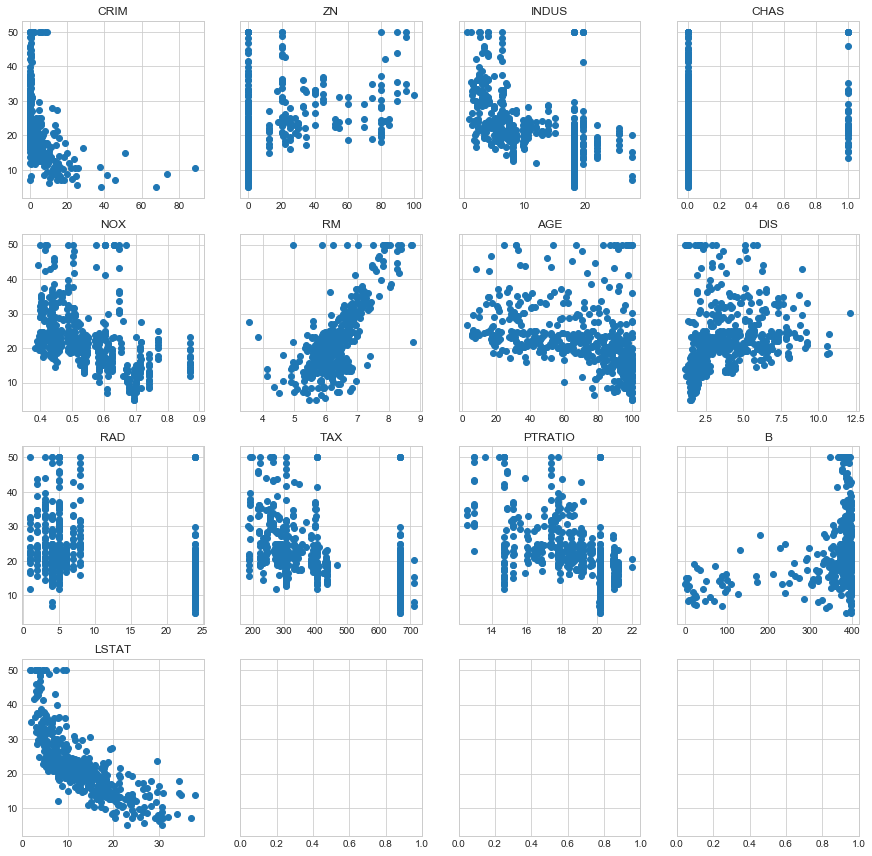

In [4]:
rows = 4
cols = 4
fig, axarr = plt.subplots(rows, cols, figsize=(15, 15), sharey=True)
for i in range(rows):
    for j in range(cols):
        idx = i * rows + j
        if idx < len(boston.feature_names):
            axarr[i, j].scatter(boston.data[:, idx], boston.target)
            axarr[i, j].set_title(boston.feature_names[idx])

## PCA
We could see from the dataset description that it consists of 13 features. We want to visualize the clusters in a two-dimensional space. [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) allow us to summarize a the dataset with a smaller amount of variables that collectively explain most of the variability in the data.

The results from a PCA depend on whetehr the variables have been individually scaled. Typically we scale each variable to have a standard deviation of one. We use the `StandardScaler`object to achieve this. The `fit_transform` method will handle both fitting the data to the model and then transforming it for us. 

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(boston.data)

The `PCA` class is available in the `sklearn.decomposition` package. We initiate the model by assigning the `n_components` parameter a value of 2, since that is the target amount of dimensions we want.

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

There was no need to split the data into training and testing sets, since we will be working with unsupervised learning later on. As a result we can directly the `fit_transform` method on our scaled data. The method will return two new dimensions with their corresponding values for each input value.

In [7]:
X_pca = pca.fit_transform(X)

We can see the proportion of the variance each component is able to explain by accessing the `explained_variance_ratio_` attribute. 

In [8]:
pca.explained_variance_ratio_

array([0.47097344, 0.11015872])

From the results we can conclude that:
- The first principal component can explain 47% of the variance.
- The second principal component can explain an additional 11% of the variance.
- Cumulatively these two components explain 58% of the variance in the data.

## Clustering
The [K-Means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) is used for partitioning a dataset into K distinct, non-overlapping clusters. To perform the clustering we must specify the desired amount of clusters afterwhich the algorithm will assign each observation to exactly on of the K clusters. In `Kmeans` we specify the desired number of clusters when creating the object using the `n_clusters` parameter. One way to identify a suitable amount of clusters for your data is to utilize the so called [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

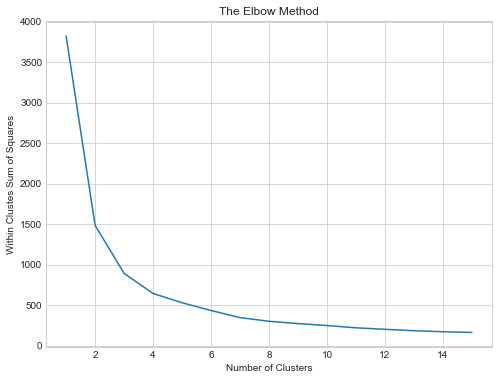

In [9]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 6))
plt.plot(range(1,16), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Clustes Sum of Squares')
plt.show()

From the visualization above we can see that the data converges at around 4 to 8 clusters. In this particular case I decided to use 5 clusters in the final model.

In [10]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10)
y_kmeans = kmeans.fit_predict(X_pca)

## Prepare the datasets
We have identified the principal components and clusters for our dataset it is time to combine all the data for use in Power BI. We will do this by creating two different datasets.
- Dataset containing the original Boston Housing data, principal components and the cluster information.
- Dataset containing information about the principal components.

In [11]:
columns = np.append(boston.feature_names,['MEDV','PC 1', 'PC 2', 'Cluster'])
data = np.concatenate((boston.data, boston.target.reshape(-1,1), X_pca, y_kmeans.reshape(-1,1)), axis=1)
df_housing = pd.DataFrame(data=data, columns=columns)

Let's have a look at the data to ensure it makes sense.

In [12]:
df_housing.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,PC 1,PC 2,Cluster
194,0.01439,60.0,2.93,0.0,0.401,6.604,18.8,6.2196,1.0,265.0,15.6,376.70,4.38,29.1,-3.800977,-0.958475,2.0
261,0.53412,20.0,3.97,0.0,0.647,7.520,89.4,2.1398,5.0,264.0,13.0,388.37,7.26,43.1,-1.401571,1.966610,3.0
360,4.54192,0.0,18.10,0.0,0.770,6.398,88.0,2.5182,24.0,666.0,20.2,374.56,7.79,25.0,2.487036,0.006287,0.0
475,6.39312,0.0,18.10,0.0,0.584,6.162,97.4,2.2060,24.0,666.0,20.2,302.76,24.10,13.3,3.074087,-0.668859,0.0
381,15.87440,0.0,18.10,0.0,0.671,6.545,99.1,1.5192,24.0,666.0,20.2,396.90,21.08,10.9,3.287619,-0.357886,0.0


The second dataset will contain information about the principal components.

In [13]:
columns = np.append(boston.feature_names,['VARRATIO'])
data = np.concatenate((pca.components_, pca.explained_variance_ratio_.reshape(-1,1)), axis=1)
df_pca = pd.DataFrame(data=data, columns=columns, index=['PC 1', 'PC 2'])

In [14]:
df_pca

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,VARRATIO
PC 1,0.249593,-0.256521,0.346861,0.005099,0.342976,-0.189437,0.313851,-0.321735,0.319817,0.338539,0.205021,-0.202732,0.309841,0.470973
PC 2,-0.313186,-0.321308,0.111816,0.456726,0.219857,0.153877,0.311748,-0.349181,-0.270398,-0.238859,-0.308704,0.234957,-0.075982,0.110159


## Visualize the data
Finally we'll visualize the data so that we have a reference of what results we should achieve in Power BI.

**Principal components**

Display a heatmap of the features and how each features weight affect the principal component value. We slice the last column from the data because it was the explained variance ratio for the principal component.

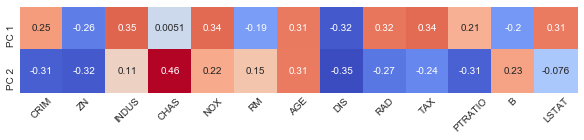

In [15]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
ax = sns.heatmap(df_pca.iloc[:,:-1], cmap='coolwarm', square=True, annot=True, cbar=False)

**Clusters by principal components**

Let's plot the clusters on a scatter plot where we use the principal components as axes.

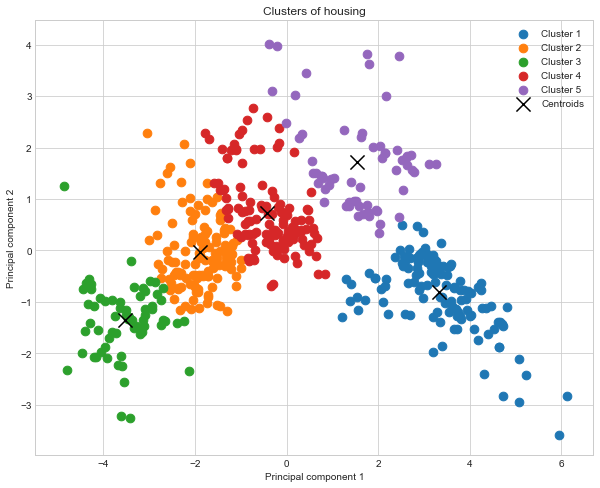

In [16]:
plt.figure(figsize=(10,8))
for i in range(kmeans.n_clusters):
    plt.scatter(X_pca[y_kmeans == i, 0], X_pca[y_kmeans == i, 1], s = 75, label = 'Cluster ' + str(i+1))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s = 200, c = 'black', label = 'Centroids')
plt.title('Clusters of housing')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend()
plt.show()

**Clusters per feature**

Plot the clusters on a scatter plot for each feature to see if there are any noticeable patterns.

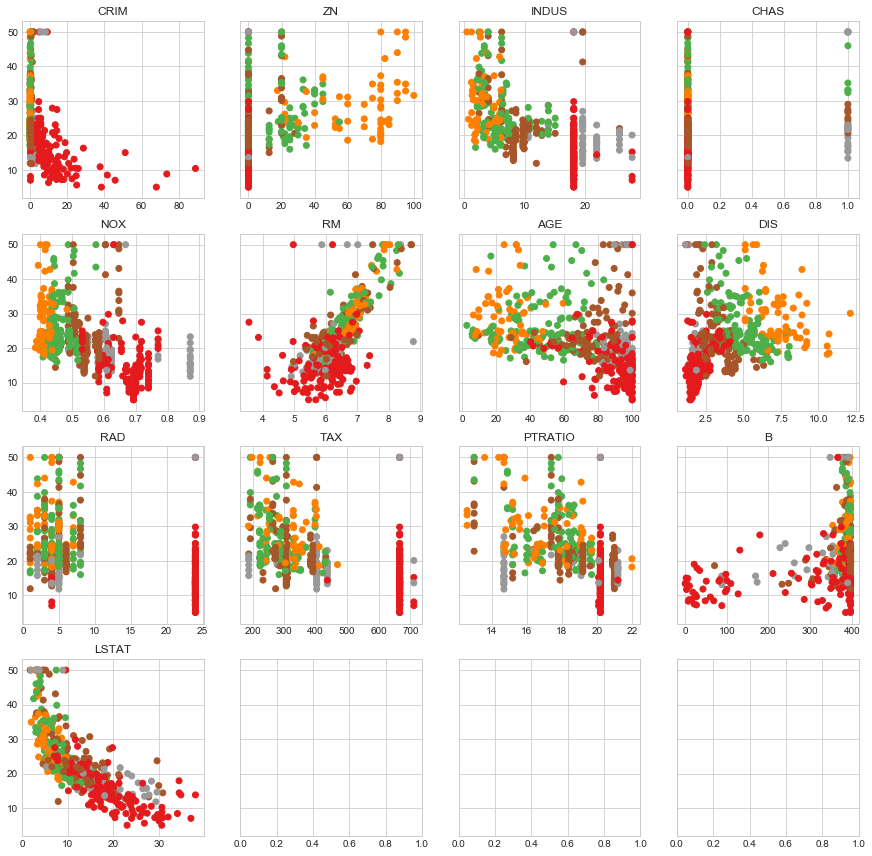

In [17]:
rows = 4
cols = 4
fif, axarr = plt.subplots(rows, cols, figsize=(15,15), sharey=True)
for i in range(rows):
    for j in range(cols):
        idx = i*rows + j
        if idx < len(boston.feature_names):
            axarr[i,j].scatter(boston.data[:,idx], boston.target, c=y_kmeans, cmap='Set1')
            axarr[i,j].set_title(boston.feature_names[idx])

**Kernel Density Estimate of median price by cluster**

Plot a KDE of the median value of the homes grouped by cluster.

C:\Users\tomra\AppData\Local\Continuum\miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


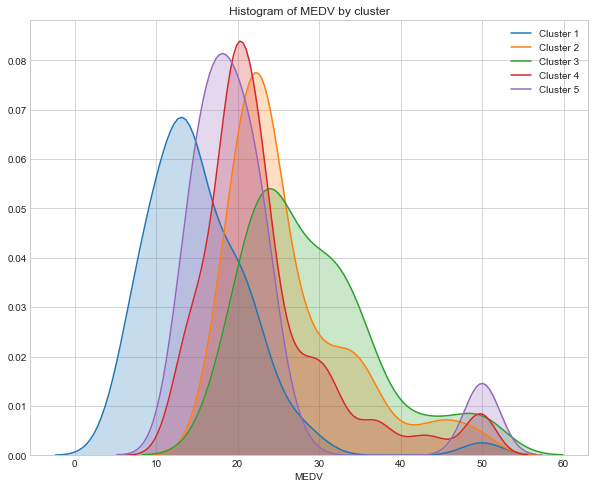

In [18]:
plt.figure(figsize=(10,8))
for i in range(kmeans.n_clusters):
    #plt.hist(boston.target[y_kmeans == i], bins=20, label = 'Cluster ' + str(i+1), alpha=0.7)
    sns.kdeplot(boston.target[y_kmeans == i], shade=True, label='Cluster ' + str(i+1))
plt.title('Histogram of MEDV by cluster')
plt.xlabel('MEDV')
plt.legend()
plt.show()